## 네이버 영화 리뷰 감성 분류하기

- 긍정 1, 부정 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 로드하기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x104fc8160>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### 2. 데이터 정제하기

In [9]:
# document 열과 label 열의 중복을 제외한 값이 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 150,000 개의 샘플 중, 중복 제거한 결과 146,182 개
- 약 4,000개의 중복 샘플이 존재한다

In [10]:
# 중복 제거해주기
train_data.drop_duplicates(subset=['document'], inplace=True)
print("총 샘플 수 : ", len(train_data))

총 샘플 수 :  146183


<AxesSubplot:>

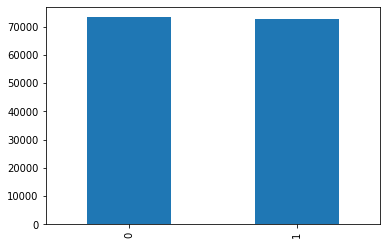

In [11]:
train_data['label'].value_counts().plot(kind='bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='총 개수'))


   label   총 개수
0      0  73342
1      1  72841


In [13]:
print(train_data.isnull().values.any())

True


In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [17]:
print("NaN 및 중복 제거된 훈련 데이터 길이 : ", len(train_data))

NaN 및 중복 제거된 훈련 데이터 길이 :  146182


#### 데이터 전처리
- 온점(.), ?, 등 특수문자
- 한글의 경우
    - https://www.unicode.org/charts/PDF/U3130.pdf
    - ㄱ~ㅎ : 3131 ~ 314E
    - ㅏ~ㅣ : 314F ~ 3163
    - 완성형 한글의 범위 : " 가 ~ 힣 "
        - https://www.unicode.org/charts/PDF/UAC00.pdf

In [18]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data.head()


/var/folders/jw/_38j243d5qq977z0w467cxq00000gn/T/ipykernel_26691/168246081.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


단, 리뷰의 경우 한글로 입력된게 아니었다면, 공백으로 되었을 가능성이 있기 때문에 다시 공백이 있는지 확인한다.

In [19]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # 일반 공백을 빈값으로 변경
train_data['document'].replace("",np.nan, inplace=True)
train_data.isnull().sum()

/var/folders/jw/_38j243d5qq977z0w467cxq00000gn/T/ipykernel_26691/3477708979.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # 일반 공백을 빈값으로 변경


id            0
document    789
label         0
dtype: int64

In [20]:
# Na 값 제거해주기
train_data = train_data.dropna(how='any')
len(train_data)

145393

테스트 데이터에도 마찬가지로 진행해준다.

In [21]:
# 열 기준 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)
# 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# space bar 은 빈 값으로 변경
test_data['document'] = test_data['document'].str.replace("^ +", "")
# 빈 값 Na 로 변경
test_data['document'].replace('', np.nan, inplace=True)
# Na 값 제거
test_data = test_data.dropna(how='any')

print("전처리 후 test data 개수 : ", len(test_data))

전처리 후 test data 개수 :  48852


/var/folders/jw/_38j243d5qq977z0w467cxq00000gn/T/ipykernel_26691/2889257609.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/var/folders/jw/_38j243d5qq977z0w467cxq00000gn/T/ipykernel_26691/2889257609.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("^ +", "")


### 3. 토큰화
- 불용어 제거
    - 조사 / 접속사
    - 일반적인 예시 ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [23]:
# 토큰화를 위한 형태소 분석기 KoNLPy Okt
okt = Okt()
# stem = True 로 일정 수준의 정규화 수행
# ex) 이런 -> 이렇다, 만드는게 -> 만들다
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '나다', '뻔']

In [24]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
X_train[:3]

100%|██████████| 145393/145393 [03:15<00:00, 742.29it/s]


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [25]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed)
X_test[:3]

100%|██████████| 48852/48852 [01:10<00:00, 691.37it/s]


[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

### 4. 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록, 정수 인코딩을 해준다.
- 단어 집합을 만들어준다.

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

- 각 정수는 전체 훈련 데이터에서 빈도수가 높은 순으로부터 부여된다
    - 빈도수가 낮은 단어들은 배제해보자

In [27]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 3개보다 적은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 3개보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key, value로 받기
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq+value
    
    # 단어 등장수가 threshold 보다 작은 경우
    if ( value < threshold):
        rare_cnt += 1
        rare_freq += value

print("단어 집합(vocabulary)의 크기 : ", total_cnt)
print("등장 빈도가 %s 번 이하인 회귀 단어의 수 : %s"%(threshold-1, rare_cnt))
print('단어 집합에서 회귀 단어 비율의 비율 : ', rare_cnt/total_cnt*100)
print('전체 등장 빈도에서 회귀 단어 등장 빈도 비율 : ', rare_freq/total_freq*100)

단어 집합(vocabulary)의 크기 :  43752
등장 빈도가 2 번 이하인 회귀 단어의 수 : 24337
단어 집합에서 회귀 단어 비율의 비율 :  55.62488571950996
전체 등장 빈도에서 회귀 단어 등장 빈도 비율 :  1.8715872104872904


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [29]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 5) 빈 샘플(empty samples) 제거

In [31]:
# 길이가 0인 샘플들의 인덱스 가져오기
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [32]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


/Users/sunny/miniforge3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


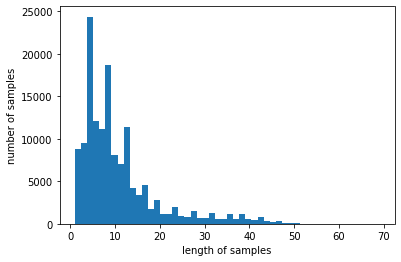

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
# 샘플 길이 특정 길이로 통일
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [35]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2022-03-14 12:21:32.551425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 12:21:32.551705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-14 12:21:32.994775: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15


2022-03-14 12:21:33.429890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 12:21:33.657166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 12:21:34.221382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1815/1815 [==============================] - ETA: 0s - loss: 0.5528 - acc: 0.7128

2022-03-14 12:22:15.916842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 12:22:15.972172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_acc improved from -inf to 0.76861, saving model to best_model.h5
1815/1815 [==============================] - 48s 26ms/step - loss: 0.5528 - acc: 0.7128 - val_loss: 0.4767 - val_acc: 0.7686
Epoch 2/15
1813/1815 [============================>.] - ETA: 0s - loss: 0.4547 - acc: 0.7838
Epoch 00002: val_acc improved from 0.76861 to 0.79396, saving model to best_model.h5
1815/1815 [==============================] - 46s 25ms/step - loss: 0.4547 - acc: 0.7838 - val_loss: 0.4384 - val_acc: 0.7940
Epoch 3/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.4239 - acc: 0.8024
Epoch 00003: val_acc improved from 0.79396 to 0.80298, saving model to best_model.h5
1815/1815 [==============================] - 46s 25ms/step - loss: 0.4239 - acc: 0.8024 - val_loss: 0.4204 - val_acc: 0.8030
Epoch 4/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.4049 - acc: 0.8133
Epoch 00004: val_acc improved from 0.80298 to 0.81283, saving model to best_model.h5
1815/181

In [42]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

   7/1527 [..............................] - ETA: 14s - loss: 0.3919 - acc: 0.8304 

2022-03-14 13:11:23.095320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 13:11:23.155334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1527/1527 [==============================] - 21s 14ms/step - loss: 0.3825 - acc: 0.8291

 테스트 정확도: 0.8291


In [40]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [43]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

   5/1527 [..............................] - ETA: 21s - loss: 0.3528 - acc: 0.8438 

2022-03-16 12:28:17.199221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 12:28:17.258001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1527/1527 [==============================] - 21s 14ms/step - loss: 0.3825 - acc: 0.8291

 테스트 정확도: 0.8291


In [44]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

2022-03-16 12:28:38.629112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 12:28:38.777776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


68.44% 확률로 긍정 리뷰입니다.

